In [1]:
# -- Import libraries --
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as tfk
from scipy.stats import norm, laplace

tfkl = tfk.layers

## Data Preprocessing

In [2]:
data = pd.read_csv('Cleaned_Youtube_Data.csv')
data.head()

,Unnamed: 0,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,country,category_names,Popularity_score
0,0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL S CHANNEL video 4k lens drone GEAR CA...,USA,People & Blogs,1131.528370
1,1,1ZAPwfrtAFY,17.14.11,The Trump Presidency Last Week Tonight John Ol...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,last week tonight trump presidency last week t...,2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,One year presidential election John Oliver dis...,USA,Entertainment,461.981128
2,2,5qpjK5DgCt4,17.14.11,Racist Superman Rudy Mancuso King Bach Lele Pons,Rudy Mancuso,23,2017-11-12T19:05:24.000Z,racist superman rudy mancuso king bach racist ...,3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO n nSUBSCRIBE FOR WATCH...,USA,Comedy,353.815380
3,3,puqaWrEC7tY,17.14.11,Nickelback Lyrics Real Fake,Good Mythical Morning,24,2017-11-13T11:00:04.000Z,rhett link gmm good mythical morning rhett lin...,343168,10172,666,2146,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,False,Today find Link Nickelback amateur secret Nick...,USA,Entertainment,57.363326
4,4,d380meD0W0M,17.14.11,I Dare You GOING BALD,nigahiga,24,2017-11-12T18:01:41.000Z,ryan higa higatv nigahiga dare idy rhpc dares ...,2095731,132235,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know since show back might best episode yet ...,USA,Entertainment,1080.400002


In [3]:
# Drop the data that contains non-English characters.
detect_non_eng = lambda x: 1 if re.search('[^A-Za-z0-9_\-\'\s]', 
                                          ''.join([str(x['title']), str(x['tags']), str(x['description'])])) else 0
non_eng = data.apply(detect_non_eng, axis=1)
idx = list(non_eng[non_eng == 0].index)
data_eng = data.iloc[idx]

In [4]:
# Split training and test data.
np.random.seed(0)
idx_train = np.random.choice(len(data_eng), 20000, replace=False)
idx_test = np.setdiff1d(np.arange(len(data_eng)), idx_train, assume_unique=True)
data_train = data_eng.iloc[idx_train]
data_test = data_eng.iloc[idx_test]

In [5]:
# Setting up GloVe embedding array
GloVe_embeddings = {}

with open('glove.6B.50d.txt', 'rb') as f:
    for line in f:
        values = line.split()
        word = values[0].decode("utf-8")
        coefs = np.asarray(values[1:], dtype='float32')
        GloVe_embeddings[word] = coefs

In [6]:
def word_vec(data):
    tokenizer = tfk.preprocessing.text.Tokenizer()
    tokenizer.fit_on_texts(data)
    word_index = tokenizer.word_index
    num_word = len(word_index)+1

    embedding_matrix = np.zeros((num_word, 50))
    for word, idx in word_index.items():
        embedding_vector = GloVe_embeddings.get(word)
        if embedding_vector is not None:
            embedding_matrix[idx, :] = embedding_vector
    
    return tokenizer, word_index, num_word, embedding_matrix

In [7]:
def preprocessing(col_name):
    train = list(data_train[col_name].map(lambda x: str(x).lower()))
    test = list(data_test[col_name].map(lambda x: str(x).lower()))
    
    tokenizer, word_index, num_word, embedding_matrix  = word_vec(train)
    train_sequences = tokenizer.texts_to_sequences(train)
    test_sequences = tokenizer.texts_to_sequences(test)
    
    max_seq_len = np.max(list(map(len, train_sequences)))
    train_sequences_pad = tfk.preprocessing.sequence.pad_sequences(train_sequences, maxlen=max_seq_len)
    test_sequences_pad = tfk.preprocessing.sequence.pad_sequences(test_sequences, maxlen=max_seq_len)
    
    return num_word, max_seq_len, embedding_matrix, train_sequences_pad, test_sequences_pad

In [8]:
num_word1, max_seq_len1, embedding_matrix1, train_sequences1, test_sequences1 = preprocessing('title')
num_word2, max_seq_len2, embedding_matrix2, train_sequences2, test_sequences2 = preprocessing('tags')
num_word3, max_seq_len3, embedding_matrix3, train_sequences3, test_sequences3 = preprocessing('description')
train_score = np.array(data_train['Popularity_score'])
test_score = np.array(data_test['Popularity_score'])

## Get the initial weights of the LSTM and feed-forward layers for the heteroscedastic model

In [9]:
title = tfk.Input(shape=(max_seq_len1,), name='title')
tags = tfk.Input(shape=(max_seq_len2,), name='tags')
description = tfk.Input(shape=(max_seq_len3,), name='description')

x1 = tfkl.Embedding(num_word1, 50, mask_zero=True, name='title_embedding')(title)
x2 = tfkl.Embedding(num_word2, 50, mask_zero=True, name='tags_embedding')(tags)
x3 = tfkl.Embedding(num_word3, 50, mask_zero=True, name='description_embedding')(description)

x1 = tfkl.LSTM(8, name='title_lstm')(x1)
x2 = tfkl.LSTM(8, name='tags_lstm')(x2)
x3 = tfkl.LSTM(8, name='description_lstm')(x3)

concat = tfkl.Concatenate()([x1, x2, x3])
mean = tfkl.Dense(8, activation=tf.nn.relu, name='mean1')(concat)
out = tfkl.Dense(1, activation=None, name='mean2')(mean)

model_huber = tfk.Model(inputs=[title, tags, description], outputs=out)

In [10]:
model_huber.layers[3].set_weights([embedding_matrix1])
model_huber.layers[3].trainable = False
model_huber.layers[4].set_weights([embedding_matrix2])
model_huber.layers[4].trainable = False
model_huber.layers[5].set_weights([embedding_matrix3])
model_huber.layers[5].trainable = False

model_huber.compile(optimizer=tfk.optimizers.Adam(learning_rate=0.01), loss=tf.keras.losses.Huber())
model_huber.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
title (InputLayer)              [(None, 22)]         0                                            
__________________________________________________________________________________________________
tags (InputLayer)               [(None, 110)]        0                                            
__________________________________________________________________________________________________
description (InputLayer)        [(None, 714)]        0                                            
__________________________________________________________________________________________________
title_embedding (Embedding)     (None, 22, 50)       1025000     title[0][0]                      
______________________________________________________________________________________________

In [11]:
model_huber.fit([train_sequences1, train_sequences2, train_sequences3], train_score, steps_per_epoch=50, epochs=50)

Train on 20000 samples
Epoch 1/50
20000/20000 [==============================] - 28s 1ms/sample - loss: 130.7754
Epoch 2/50
20000/20000 [==============================] - 17s 861us/sample - loss: 125.5451
Epoch 3/50
20000/20000 [==============================] - 17s 872us/sample - loss: 122.1796
Epoch 4/50
20000/20000 [==============================] - 18s 876us/sample - loss: 120.1562
Epoch 5/50
20000/20000 [==============================] - 17s 870us/sample - loss: 118.4761
Epoch 6/50
20000/20000 [==============================] - 18s 882us/sample - loss: 117.2360
Epoch 7/50
20000/20000 [==============================] - 17s 872us/sample - loss: 116.6839
Epoch 8/50
20000/20000 [==============================] - 18s 882us/sample - loss: 115.6005
Epoch 9/50
20000/20000 [==============================] - 18s 888us/sample - loss: 114.7518
Epoch 10/50
20000/20000 [==============================] - 18s 886us/sample - loss: 113.7185
Epoch 11/50
20000/20000 [==============================] -

In [12]:
pred_huber = model_huber.predict([test_sequences1, test_sequences2, test_sequences3])

In [13]:
pred_huber[:50]

array([[2.4838152e+01],
       [1.5393068e+02],
       [5.2339337e+02],
       [1.4113623e-01],
       [1.9265835e+00],
       [3.9348946e+00],
       [3.4172861e+02],
       [6.6442792e+02],
       [2.1206303e+01],
       [7.6488581e+00],
       [1.0491849e+01],
       [1.1252683e+02],
       [4.2227013e+01],
       [5.3192759e+00],
       [7.5885172e+00],
       [4.4831894e+01],
       [6.2167206e+00],
       [4.5590854e+02],
       [5.1985559e+00],
       [3.9589522e+00],
       [6.6574688e+00],
       [9.7339697e+00],
       [3.2375187e+01],
       [5.4184460e+01],
       [2.8443272e+01],
       [7.9805466e+01],
       [4.2424917e+00],
       [1.9764795e+01],
       [5.0538549e+00],
       [9.2765251e+01],
       [8.5214722e+01],
       [2.4925262e+02],
       [2.7590151e+01],
       [2.2249348e+01],
       [8.7521887e+00],
       [3.3702496e+01],
       [1.0535060e+01],
       [5.7724083e+01],
       [1.8706955e+01],
       [9.7887115e+00],
       [2.7505333e+00],
       [4.027464

In [14]:
test_score[:50]

array([ 1.34310063e+00,  3.13644825e+00,  4.99834918e+00, -2.45235257e+00,
        6.30749014e-02,  2.33172746e-01,  3.37902689e+01,  2.06962950e+02,
        1.35291631e+00,  3.27000229e+01,  3.41647214e-01,  3.96390706e+01,
        1.21089419e+01,  1.05538047e+01,  4.00034228e-01,  7.68437074e+02,
        1.37633659e-01,  7.69972405e+01,  1.31809788e+00,  2.80477886e+00,
        3.96033518e+00,  1.41770971e+01,  3.92009272e+02,  5.41228937e+01,
        6.87709172e+01,  5.83302340e+00,  6.88199465e+00,  3.62935620e-01,
       -1.25869135e+01,  4.90032070e-01,  1.65053976e+01,  2.53796854e+00,
        6.40074330e+01,  2.51176092e+01,  4.89803101e-02,  1.20931246e+01,
        1.12034811e+01,  9.40251031e+01,  2.10913148e+00,  1.81591419e-01,
        3.57796993e-02,  1.18056668e+01,  5.76457063e+00,  2.19124700e-01,
        3.01007831e+02,  1.23725565e+02,  5.43138404e+01,  4.69597457e+02,
        1.57391909e+01,  1.02915952e-02])

## Heteroscedastic model with Gaussian distribution assumption

In [15]:
title = tfk.Input(shape=(max_seq_len1,), name='title')
tags = tfk.Input(shape=(max_seq_len2,), name='tags')
description = tfk.Input(shape=(max_seq_len3,), name='description')
score = tfk.Input(shape=(1,), name='score')

x1 = tfkl.Embedding(num_word1, 50, mask_zero=True, name='title_embedding')(title)
x2 = tfkl.Embedding(num_word2, 50, mask_zero=True, name='tags_embedding')(tags)
x3 = tfkl.Embedding(num_word3, 50, mask_zero=True, name='description_embedding')(description)

x1 = tfkl.LSTM(8, name='title_lstm')(x1)
x2 = tfkl.LSTM(8, name='tags_lstm')(x2)
x3 = tfkl.LSTM(8, name='description_lstm')(x3)

concat = tfkl.Concatenate()([x1, x2, x3])
mean = tfkl.Dense(8, activation=tf.nn.relu, name='mean1')(concat)
mean = tfkl.Dense(1, activation=None, name='mean2')(mean)
std = tfkl.Dense(8, activation=tf.nn.relu, name='std1')(concat)
std = tfkl.Dense(1, activation=tf.nn.softplus, name='std2')(std)
out = tfkl.Concatenate()([mean, std])
loss = tf.reduce_mean(tf.square((score - mean)/std) + 2*tf.math.log(std) + tf.math.log(2*np.pi))/2

model_gaussian = tfk.Model(inputs=[title, tags, description, score], outputs=out)
model_gaussian.add_loss(loss)

In [16]:
model_gaussian.layers[3].set_weights([embedding_matrix1])
model_gaussian.layers[3].trainable = False
model_gaussian.layers[4].set_weights([embedding_matrix2])
model_gaussian.layers[4].trainable = False
model_gaussian.layers[5].set_weights([embedding_matrix3])
model_gaussian.layers[5].trainable = False
model_gaussian.layers[6].set_weights(model_huber.layers[6].get_weights())
model_gaussian.layers[7].set_weights(model_huber.layers[7].get_weights())
model_gaussian.layers[8].set_weights(model_huber.layers[8].get_weights())
model_gaussian.layers[10].set_weights(model_huber.layers[10].get_weights())
model_gaussian.layers[12].set_weights(model_huber.layers[11].get_weights())

model_gaussian.compile(optimizer=tfk.optimizers.Adam(learning_rate=0.01))
model_gaussian.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
title (InputLayer)              [(None, 22)]         0                                            
__________________________________________________________________________________________________
tags (InputLayer)               [(None, 110)]        0                                            
__________________________________________________________________________________________________
description (InputLayer)        [(None, 714)]        0                                            
__________________________________________________________________________________________________
title_embedding (Embedding)     (None, 22, 50)       1025000     title[0][0]                      
____________________________________________________________________________________________

In [17]:
model_gaussian.fit([train_sequences1, train_sequences2, train_sequences3, train_score], steps_per_epoch=50, epochs=20)

Train on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 30s 2ms/sample - loss: 97820.6190
Epoch 2/20
20000/20000 [==============================] - 18s 881us/sample - loss: 9339.3790
Epoch 3/20
20000/20000 [==============================] - 18s 914us/sample - loss: 4605.7104
Epoch 4/20
20000/20000 [==============================] - 19s 947us/sample - loss: 2960.6592
Epoch 5/20
20000/20000 [==============================] - 19s 948us/sample - loss: 2153.7727
Epoch 6/20
20000/20000 [==============================] - 19s 945us/sample - loss: 1743.4241
Epoch 7/20
20000/20000 [==============================] - 19s 952us/sample - loss: 1436.7674
Epoch 8/20
20000/20000 [==============================] - 19s 948us/sample - loss: 1247.8626
Epoch 9/20
20000/20000 [==============================] - 19s 950us/sample - loss: 1089.2423
Epoch 10/20
20000/20000 [==============================] - 19s 948us/sample - loss: 971.6792
Epoch 11/20
20000/20000 [=======================

In [18]:
# Get test loss
model_gaussian.evaluate([test_sequences1, test_sequences2, test_sequences3, test_score])

3818/3818 [==============================] - 10s 3ms/sample - loss: 742.5018


742.5017877321958

In [19]:
pred_gaussian = model_gaussian.predict([test_sequences1, test_sequences2, test_sequences3, test_score])

In [20]:
def plot_gaussian_distribution(idx):
    loc, scale = pred_gaussian[idx]
    x_min = norm.ppf(0.001, loc, scale)
    x_max = norm.ppf(0.999, loc, scale)
    ci_min = norm.ppf(0.975, loc, scale)
    ci_max = norm.ppf(0.025, loc, scale)
    x = np.linspace(x_min, x_max, 1000)
    y = norm.pdf(x, loc, scale)
    x_ci = np.linspace(ci_min, ci_max, 100)
    y_ci = norm.pdf(x_ci, loc, scale)
    fig, ax = plt.subplots(figsize=(10,6))
    plt.style.use('fivethirtyeight')
    ax.plot(x, y)

    ax.fill_between(x_ci, y_ci, 0, alpha=0.3, color='b')
    ax.fill_between(x, y, 0, alpha=0.3)
    ax.axvline(x=test_score[idx], color='r')
    ax.grid(linewidth=2)
    plt.show()

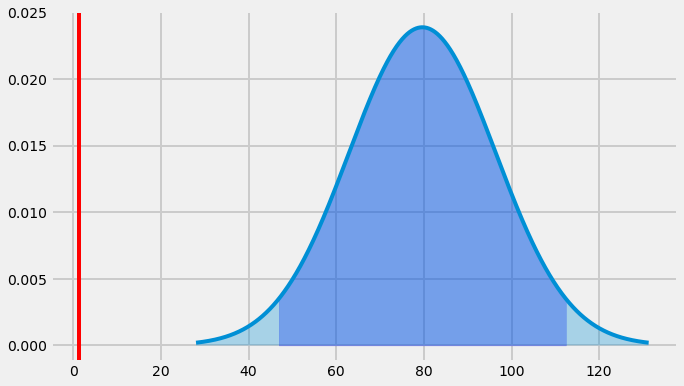

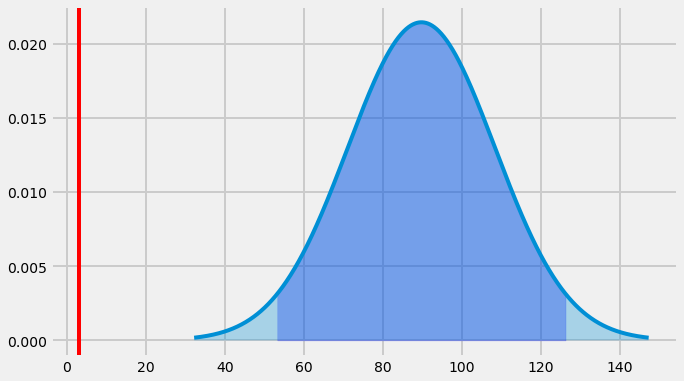

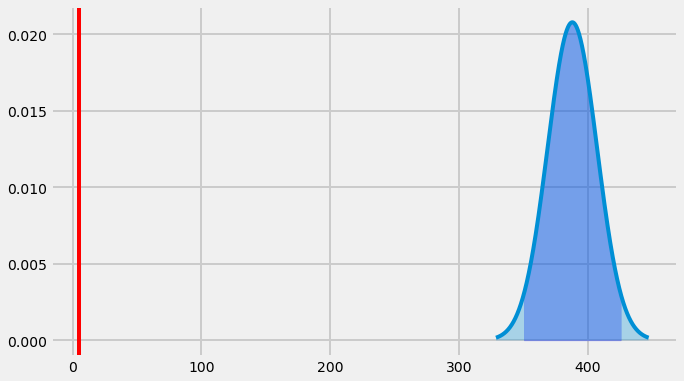

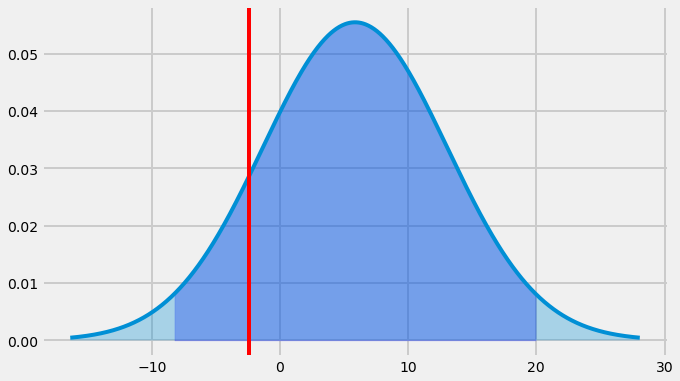

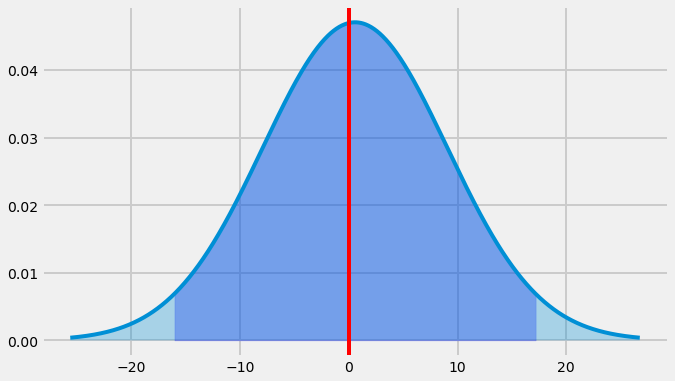

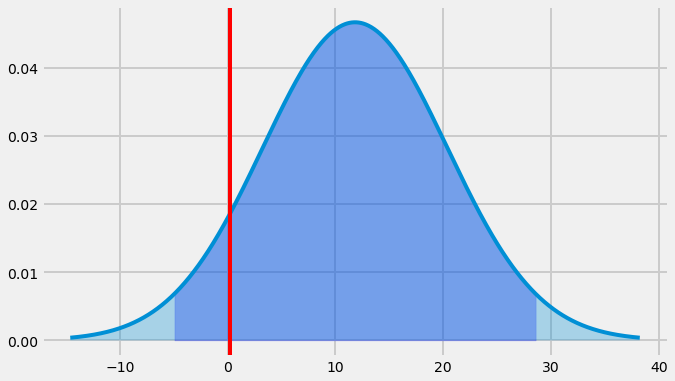

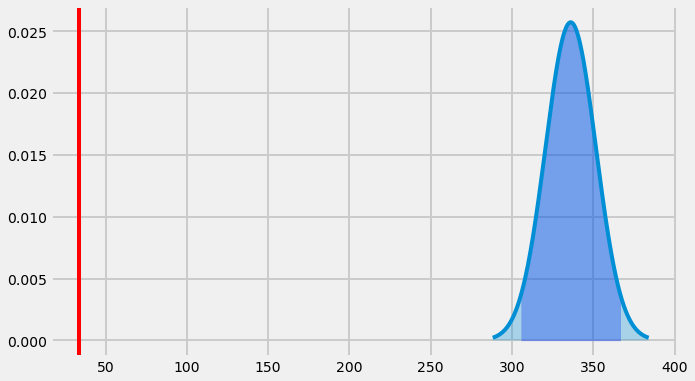

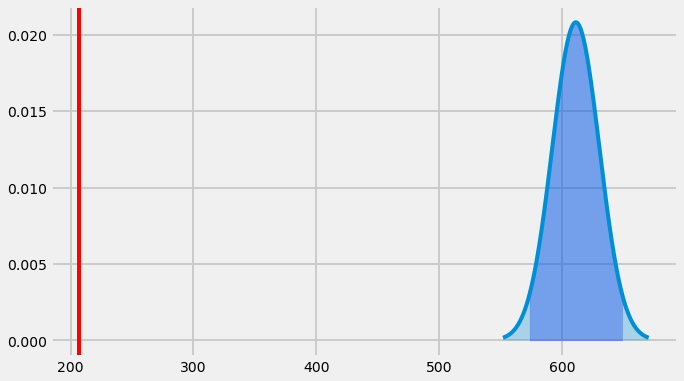

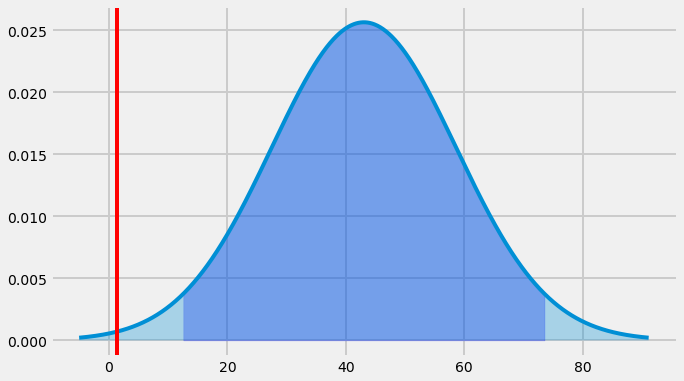

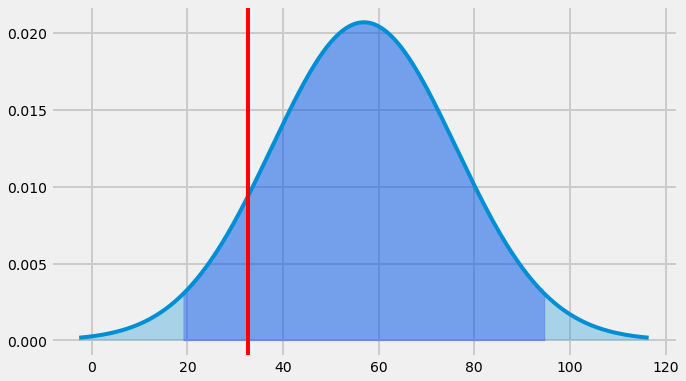

In [55]:
plot_gaussian_distribution(4)

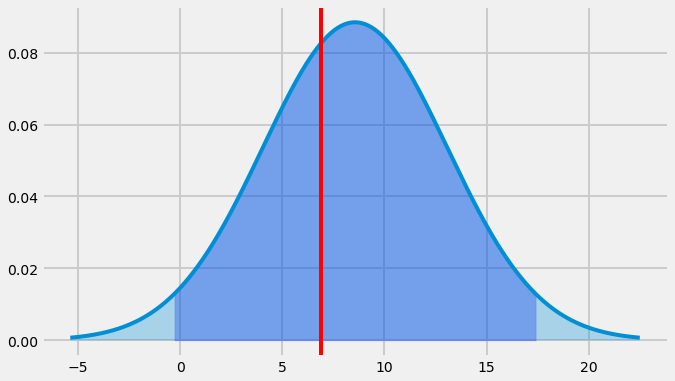

In [57]:
plot_gaussian_distribution(26)

In [23]:
# Get the proportion of test data with true value in the 95% confidence interval of predicted distribution.
k_gaussian = norm.ppf(0.975, 0, 1)
ci_min_gaussian = pred_gaussian[:, 0] - k_gaussian*pred_gaussian[:, 1]
ci_max_gaussian = pred_gaussian[:, 0] + k_gaussian*pred_gaussian[:, 1]

In [24]:
n_gaussian = 0
for i in range(len(test_score)):
    if ci_min_gaussian[i] <= test_score[i] <= ci_max_gaussian[i]:
        n_gaussian += 1
n_gaussian/len(test_score)

0.34913567312729177

## Heteroscedastic model with Laplace (Double Exponential) distribution assumption

In [38]:
title = tfk.Input(shape=(max_seq_len1,), name='title')
tags = tfk.Input(shape=(max_seq_len2,), name='tags')
description = tfk.Input(shape=(max_seq_len3,), name='description')
score = tfk.Input(shape=(1,), name='score')

x1 = tfkl.Embedding(num_word1, 50, mask_zero=True, name='title_embedding')(title)
x2 = tfkl.Embedding(num_word2, 50, mask_zero=True, name='tags_embedding')(tags)
x3 = tfkl.Embedding(num_word3, 50, mask_zero=True, name='description_embedding')(description)

x1 = tfkl.LSTM(8, name='title_lstm')(x1)
x2 = tfkl.LSTM(8, name='tags_lstm')(x2)
x3 = tfkl.LSTM(8, name='description_lstm')(x3)

concat = tfkl.Concatenate()([x1, x2, x3])
mean = tfkl.Dense(8, activation=tf.nn.relu, name='mean1')(concat)
mean = tfkl.Dense(1, activation=None, name='mean2')(mean)
b = tfkl.Dense(8, activation=tf.nn.relu, name='std1')(concat)
b = tfkl.Dense(1, activation=tf.nn.softplus, name='std2')(b)
out = tfkl.Concatenate()([mean, b])
loss = tf.reduce_mean(tf.abs(score - mean)/b + tf.math.log(2*b))

model_laplace = tfk.Model(inputs=[title, tags, description, score], outputs=out)
model_laplace.add_loss(loss)

In [39]:
model_laplace.layers[3].set_weights([embedding_matrix1])
model_laplace.layers[3].trainable = False
model_laplace.layers[4].set_weights([embedding_matrix2])
model_laplace.layers[4].trainable = False
model_laplace.layers[5].set_weights([embedding_matrix3])
model_laplace.layers[5].trainable = False
model_laplace.layers[6].set_weights(model_huber.layers[6].get_weights())
model_laplace.layers[7].set_weights(model_huber.layers[7].get_weights())
model_laplace.layers[8].set_weights(model_huber.layers[8].get_weights())
model_laplace.layers[10].set_weights(model_huber.layers[10].get_weights())
model_laplace.layers[12].set_weights(model_huber.layers[11].get_weights())

model_laplace.compile(optimizer=tfk.optimizers.Adam(learning_rate=0.01))
model_laplace.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
title (InputLayer)              [(None, 22)]         0                                            
__________________________________________________________________________________________________
tags (InputLayer)               [(None, 110)]        0                                            
__________________________________________________________________________________________________
description (InputLayer)        [(None, 714)]        0                                            
__________________________________________________________________________________________________
title_embedding (Embedding)     (None, 22, 50)       1025000     title[0][0]                      
____________________________________________________________________________________________

In [40]:
model_laplace.fit([train_sequences1, train_sequences2, train_sequences3, train_score], steps_per_epoch=50, epochs=20)

Train on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 26s 1ms/sample - loss: 31.5177
Epoch 2/20
20000/20000 [==============================] - 15s 763us/sample - loss: 10.4981
Epoch 3/20
20000/20000 [==============================] - 15s 756us/sample - loss: 8.6738
Epoch 4/20
20000/20000 [==============================] - 15s 759us/sample - loss: 7.8223
Epoch 5/20
20000/20000 [==============================] - 16s 788us/sample - loss: 7.3241
Epoch 6/20
20000/20000 [==============================] - 16s 781us/sample - loss: 6.9938
Epoch 7/20
20000/20000 [==============================] - 16s 813us/sample - loss: 6.7711
Epoch 8/20
20000/20000 [==============================] - 15s 763us/sample - loss: 6.5974
Epoch 9/20
20000/20000 [==============================] - 15s 764us/sample - loss: 6.4655
Epoch 10/20
20000/20000 [==============================] - 16s 779us/sample - loss: 6.3671
Epoch 11/20
20000/20000 [==============================] - 16s 784us/sample 

In [41]:
# Get test loss
model_laplace.evaluate([test_sequences1, test_sequences2, test_sequences3, test_score])

3818/3818 [==============================] - 13s 3ms/sample - loss: 6.6086


6.608563065965991

In [43]:
pred_laplace = model_laplace.predict([test_sequences1, test_sequences2, test_sequences3, test_score])

In [48]:
def plot_laplace_distribution(idx):
    loc, scale = pred_laplace[idx]
    x_min = laplace.ppf(0.001, loc, scale)
    x_max = laplace.ppf(0.999, loc, scale)
    ci_min = laplace.ppf(0.975, loc, scale)
    ci_max = laplace.ppf(0.025, loc, scale)
    x = np.linspace(x_min, x_max, 1000)
    y = laplace.pdf(x, loc, scale)
    x_ci = np.linspace(ci_min, ci_max, 100)
    y_ci = laplace.pdf(x_ci, loc, scale)
    fig, ax = plt.subplots(figsize=(10,6))
    plt.style.use('fivethirtyeight')
    ax.plot(x, y)

    ax.fill_between(x_ci, y_ci, 0, alpha=0.3, color='b')
    ax.fill_between(x, y, 0, alpha=0.3)
    ax.axvline(x=test_score[idx], color='r')
    ax.grid(linewidth=2)
    plt.show()

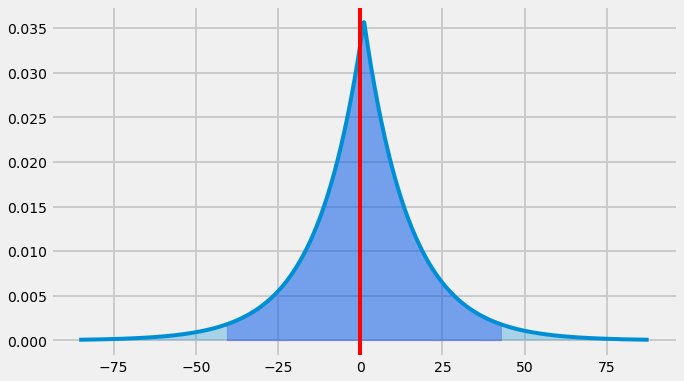

In [58]:
plot_laplace_distribution(4)

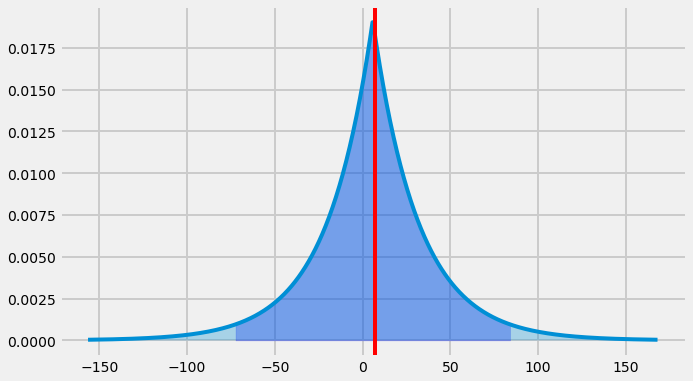

In [59]:
plot_laplace_distribution(26)

In [51]:
# Get the proportion of test data with true value in the 95% confidence interval of predicted distribution.
k_laplace = laplace.ppf(0.975, 0, 1)
ci_min_laplace = pred_laplace[:, 0] - k_laplace*pred_laplace[:, 1]
ci_max_laplace = pred_laplace[:, 0] + k_laplace*pred_laplace[:, 1]

In [52]:
n_laplace = 0
for i in range(len(test_score)):
    if ci_min_laplace[i] <= test_score[i] <= ci_max_laplace[i]:
        n_laplace += 1
n_laplace/len(test_score)

0.8758512310110005